In [11]:
from typing import Union, Iterable
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from hypex import AATest, ABTest
from hypex.utils.tutorial_data_creation import create_test_data

pd.options.display.float_format = "{:,.2f}".format

np.random.seed(42)  # needed to create example data

In [2]:
class RandomModel:
    def __init__(
        self,
        target_field: str,
        group_fields: Union[str, Iterable[str]] = None,
        diff_percentage: float = 0.01,
        sd_percentage: float = 0.1,
    ):
        self.target_field = target_field
        self.group_fields = group_fields
        self.diff_percentage = diff_percentage
        self.sd_percentage = sd_percentage

        self.params = {None: {}}

    def fill_na(self, data: pd.DataFrame):
        t_data = data.copy()
        t_data[self.group_fields] = t_data[self.group_fields].fillna("None")
        return t_data

    def fit(self, data: pd.DataFrame):
        t_data = self.fill_na(data)
        self.params["None"] = {
            "mean": t_data[self.target_field].mean(),
            "sd": t_data[self.target_field].std(),
        }
        if self.group_fields is not None:
            for group, group_data in t_data.groupby(self.group_fields):
                self.params[group] = {
                    "mean": group_data[self.target_field].mean(),
                    "sd": group_data[self.target_field].std(),
                }

        return self

    def predict(self, data: pd.DataFrame):
        t_data = self.fill_na(data)

        result = pd.concat(
            [
                pd.Series(
                    index=group_data.index,
                    data=np.random.normal(
                        self.params.get(group, self.params["None"])["mean"]
                        * self.diff_percentage,
                        self.params.get(group, self.params["None"])["sd"]
                        * self.sd_percentage,
                        len(group_data),
                    ),
                )
                for group, group_data in t_data.groupby(self.group_fields)
            ]
        )
        return t_data[self.target_field] + result

In [3]:
data = create_test_data(rs=52, na_step=10, nan_cols=['age', 'gender'])
data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry
0,0,0,0,488.00,414.44,NaN,M,E-commerce
1,1,8,1,512.50,462.22,26.00,NaN,E-commerce
2,2,7,1,483.00,479.44,25.00,M,Logistics
3,3,0,0,501.50,424.33,39.00,M,E-commerce
4,4,1,1,543.00,514.56,18.00,F,E-commerce
...,...,...,...,...,...,...,...,...
9995,9995,10,1,538.50,450.44,42.00,M,Logistics
9996,9996,0,0,500.50,430.89,26.00,F,Logistics
9997,9997,3,1,473.00,534.11,22.00,F,E-commerce
9998,9998,2,1,495.00,523.22,67.00,F,E-commerce


In [4]:
model = RandomModel(
    target_field="post_spends", group_fields=["age", "gender", "industry"], diff_percentage=0.1
)
model = model.fit(data)
data["corrected_spends"] = model.predict(data)
data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry,corrected_spends
0,0,0,0,488.00,414.44,NaN,M,E-commerce,455.15
1,1,8,1,512.50,462.22,26.00,NaN,E-commerce,503.55
2,2,7,1,483.00,479.44,25.00,M,Logistics,525.93
3,3,0,0,501.50,424.33,39.00,M,E-commerce,468.24
4,4,1,1,543.00,514.56,18.00,F,E-commerce,556.51
...,...,...,...,...,...,...,...,...,...
9995,9995,10,1,538.50,450.44,42.00,M,Logistics,491.69
9996,9996,0,0,500.50,430.89,26.00,F,Logistics,478.84
9997,9997,3,1,473.00,534.11,22.00,F,E-commerce,576.54
9998,9998,2,1,495.00,523.22,67.00,F,E-commerce,559.78


In [5]:
data["age is missing"] = data["age"].isna()*1
data["gender"] = data["gender"].fillna("None")
data["age"] = data["age"].fillna(int(data["age"].mean()))
data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry,corrected_spends,age is missing
0,0,0,0,488.00,414.44,43.00,M,E-commerce,455.15,1
1,1,8,1,512.50,462.22,26.00,None,E-commerce,503.55,0
2,2,7,1,483.00,479.44,25.00,M,Logistics,525.93,0
3,3,0,0,501.50,424.33,39.00,M,E-commerce,468.24,0
4,4,1,1,543.00,514.56,18.00,F,E-commerce,556.51,0
...,...,...,...,...,...,...,...,...,...,...
9995,9995,10,1,538.50,450.44,42.00,M,Logistics,491.69,0
9996,9996,0,0,500.50,430.89,26.00,F,Logistics,478.84,0
9997,9997,3,1,473.00,534.11,22.00,F,E-commerce,576.54,0
9998,9998,2,1,495.00,523.22,67.00,F,E-commerce,559.78,0


Group optimization:   0%|          | 0/3 [00:00<?, ?it/s]

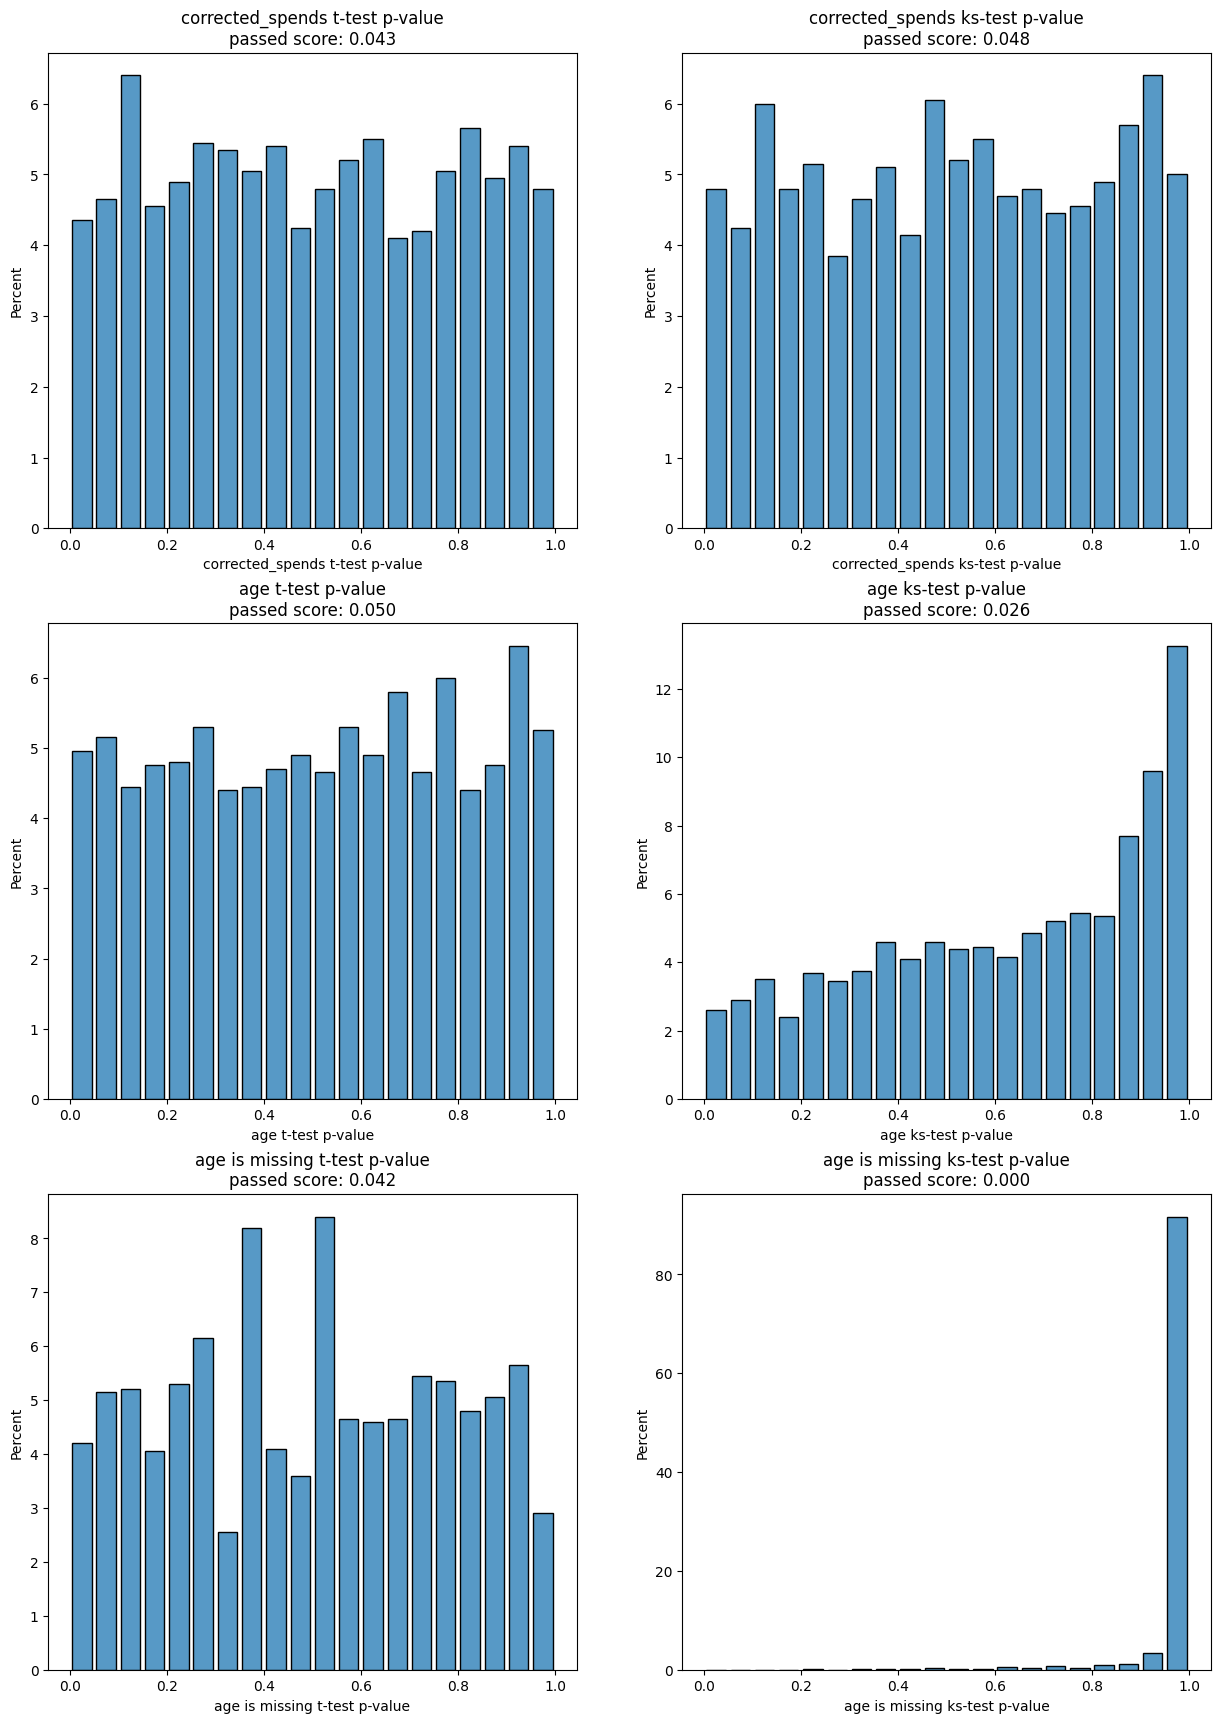

      random_state  corrected_spends a mean  corrected_spends b mean  \
0                0                   497.76                   496.97   
1                1                   497.39                   497.35   
2                2                   498.00                   496.74   
3                3                   496.42                   498.32   
4                4                   497.64                   497.10   
...            ...                      ...                      ...   
1995          1995                   497.54                   497.20   
1996          1996                   497.11                   497.63   
1997          1997                   497.81                   496.93   
1998          1998                   497.47                   497.27   
1999          1999                   496.67                   498.07   

      corrected_spends ab delta  corrected_spends ab delta %  \
0                         -0.79                        -0.16   
1      

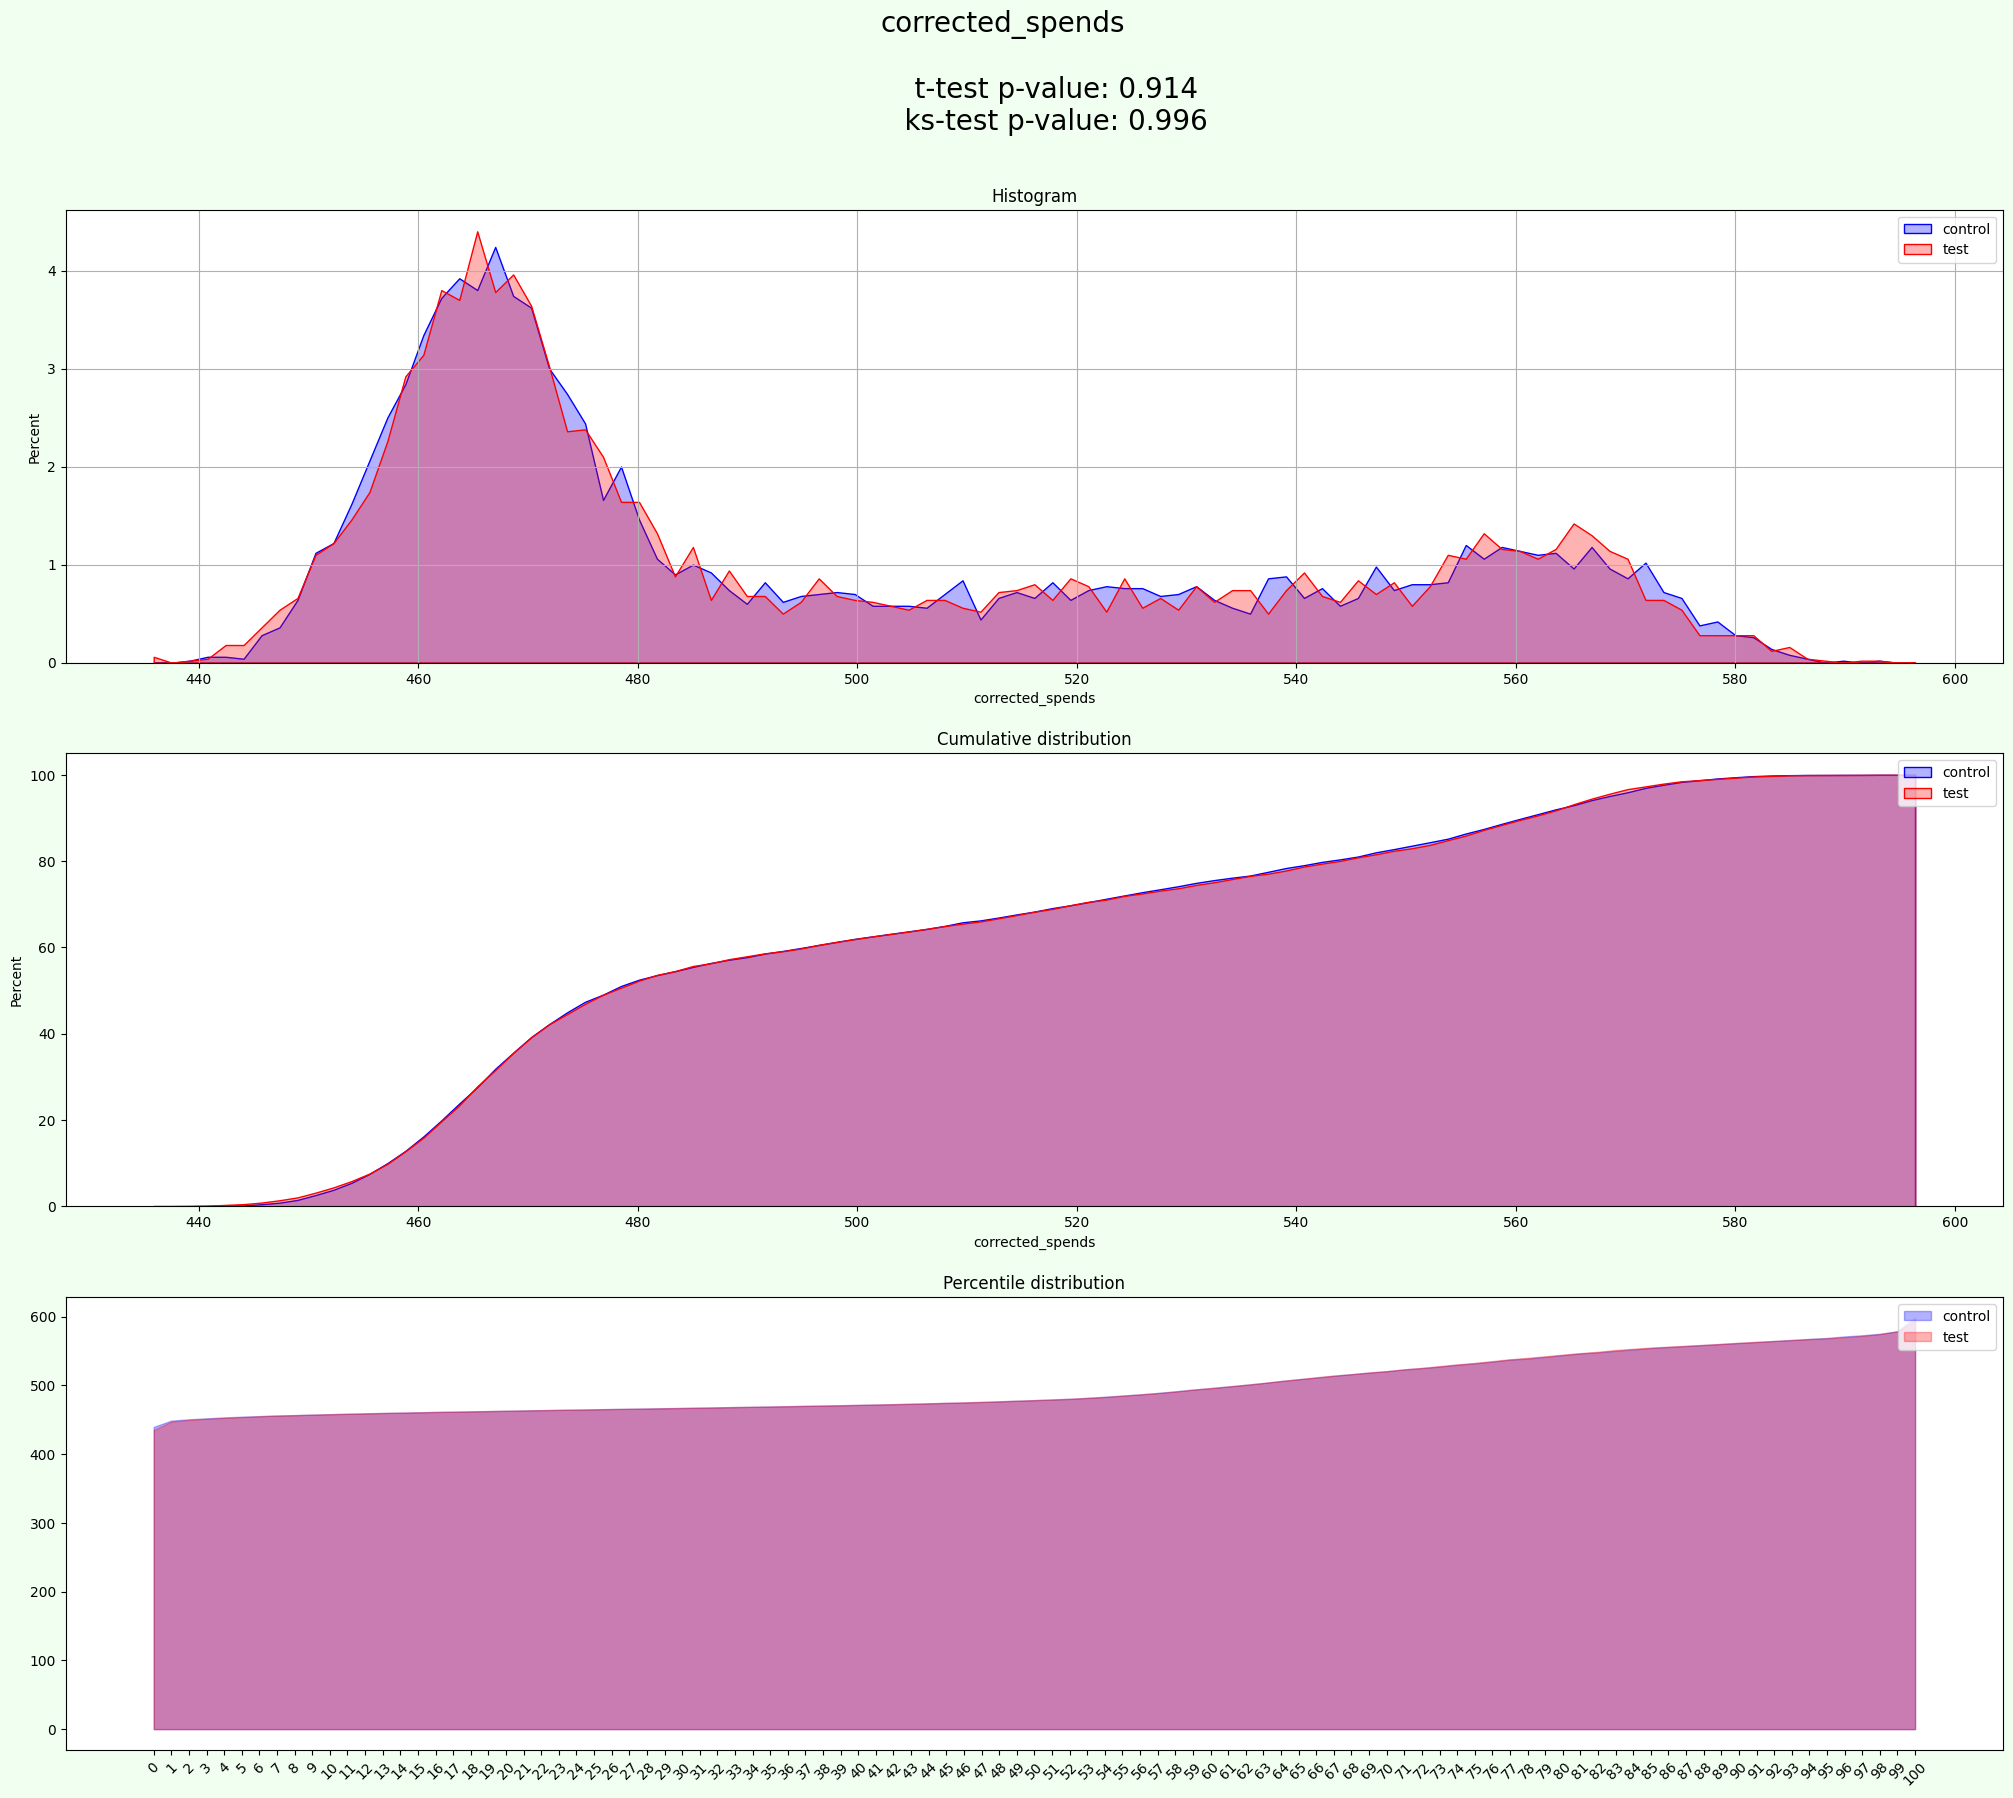

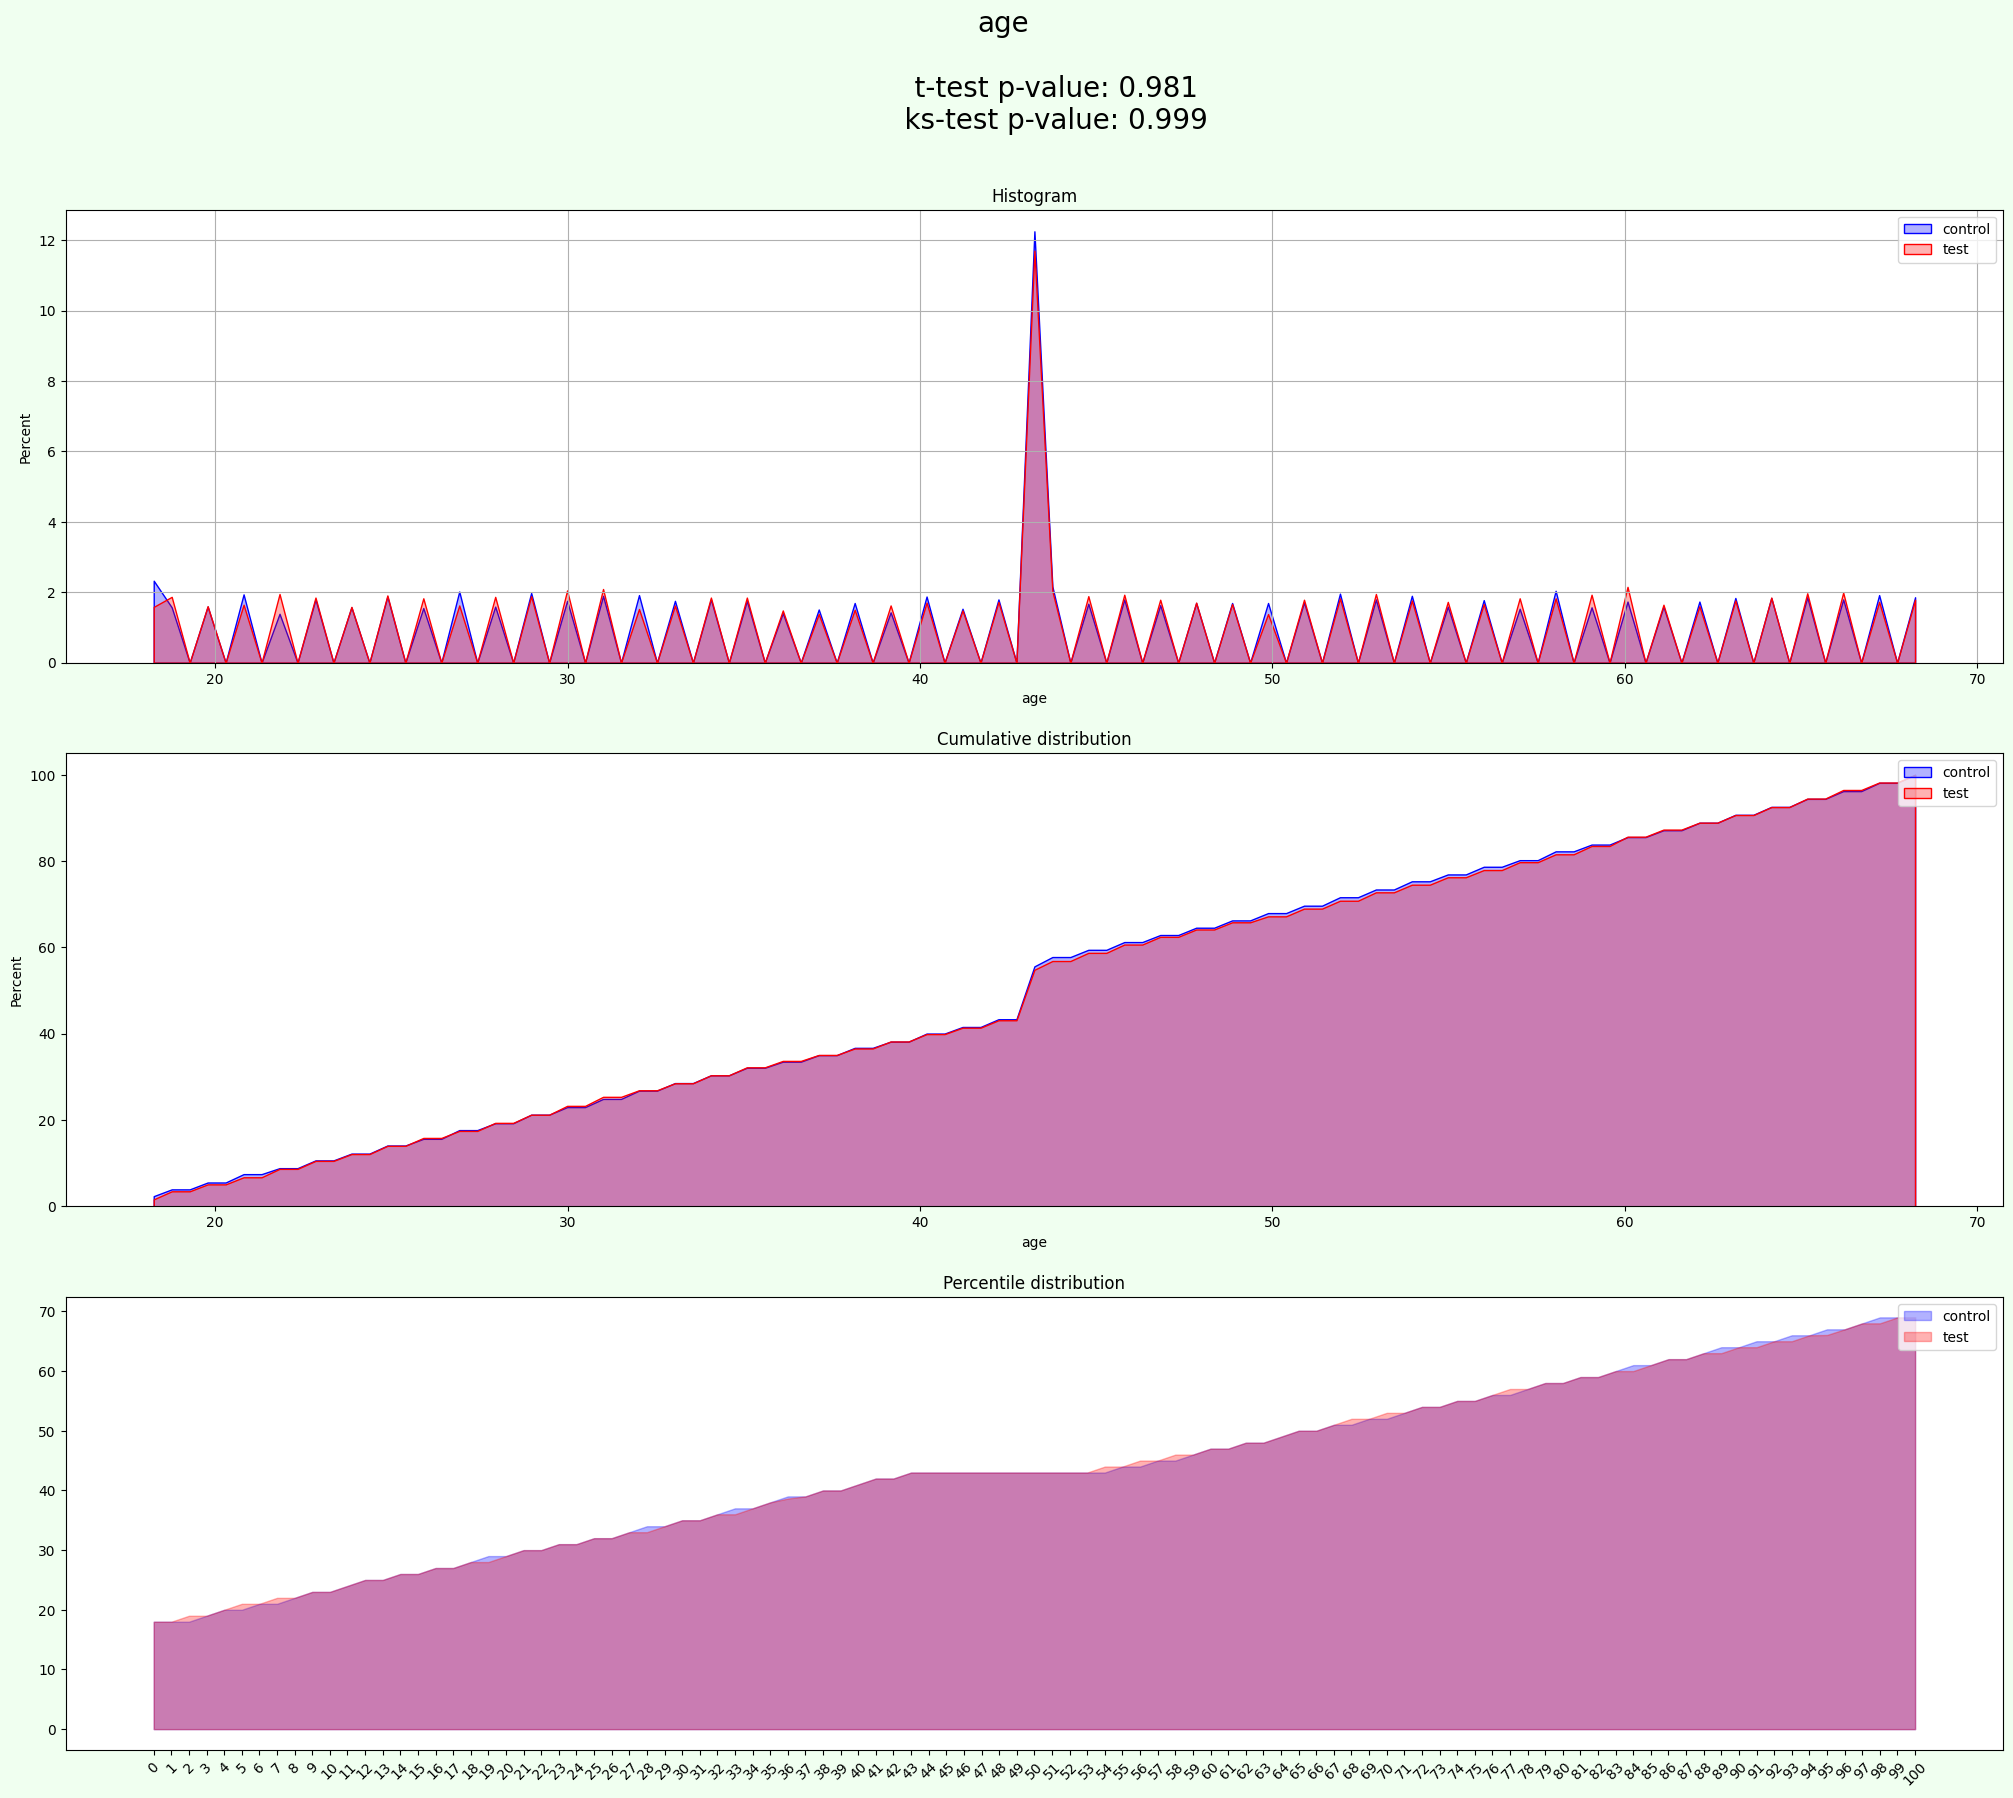

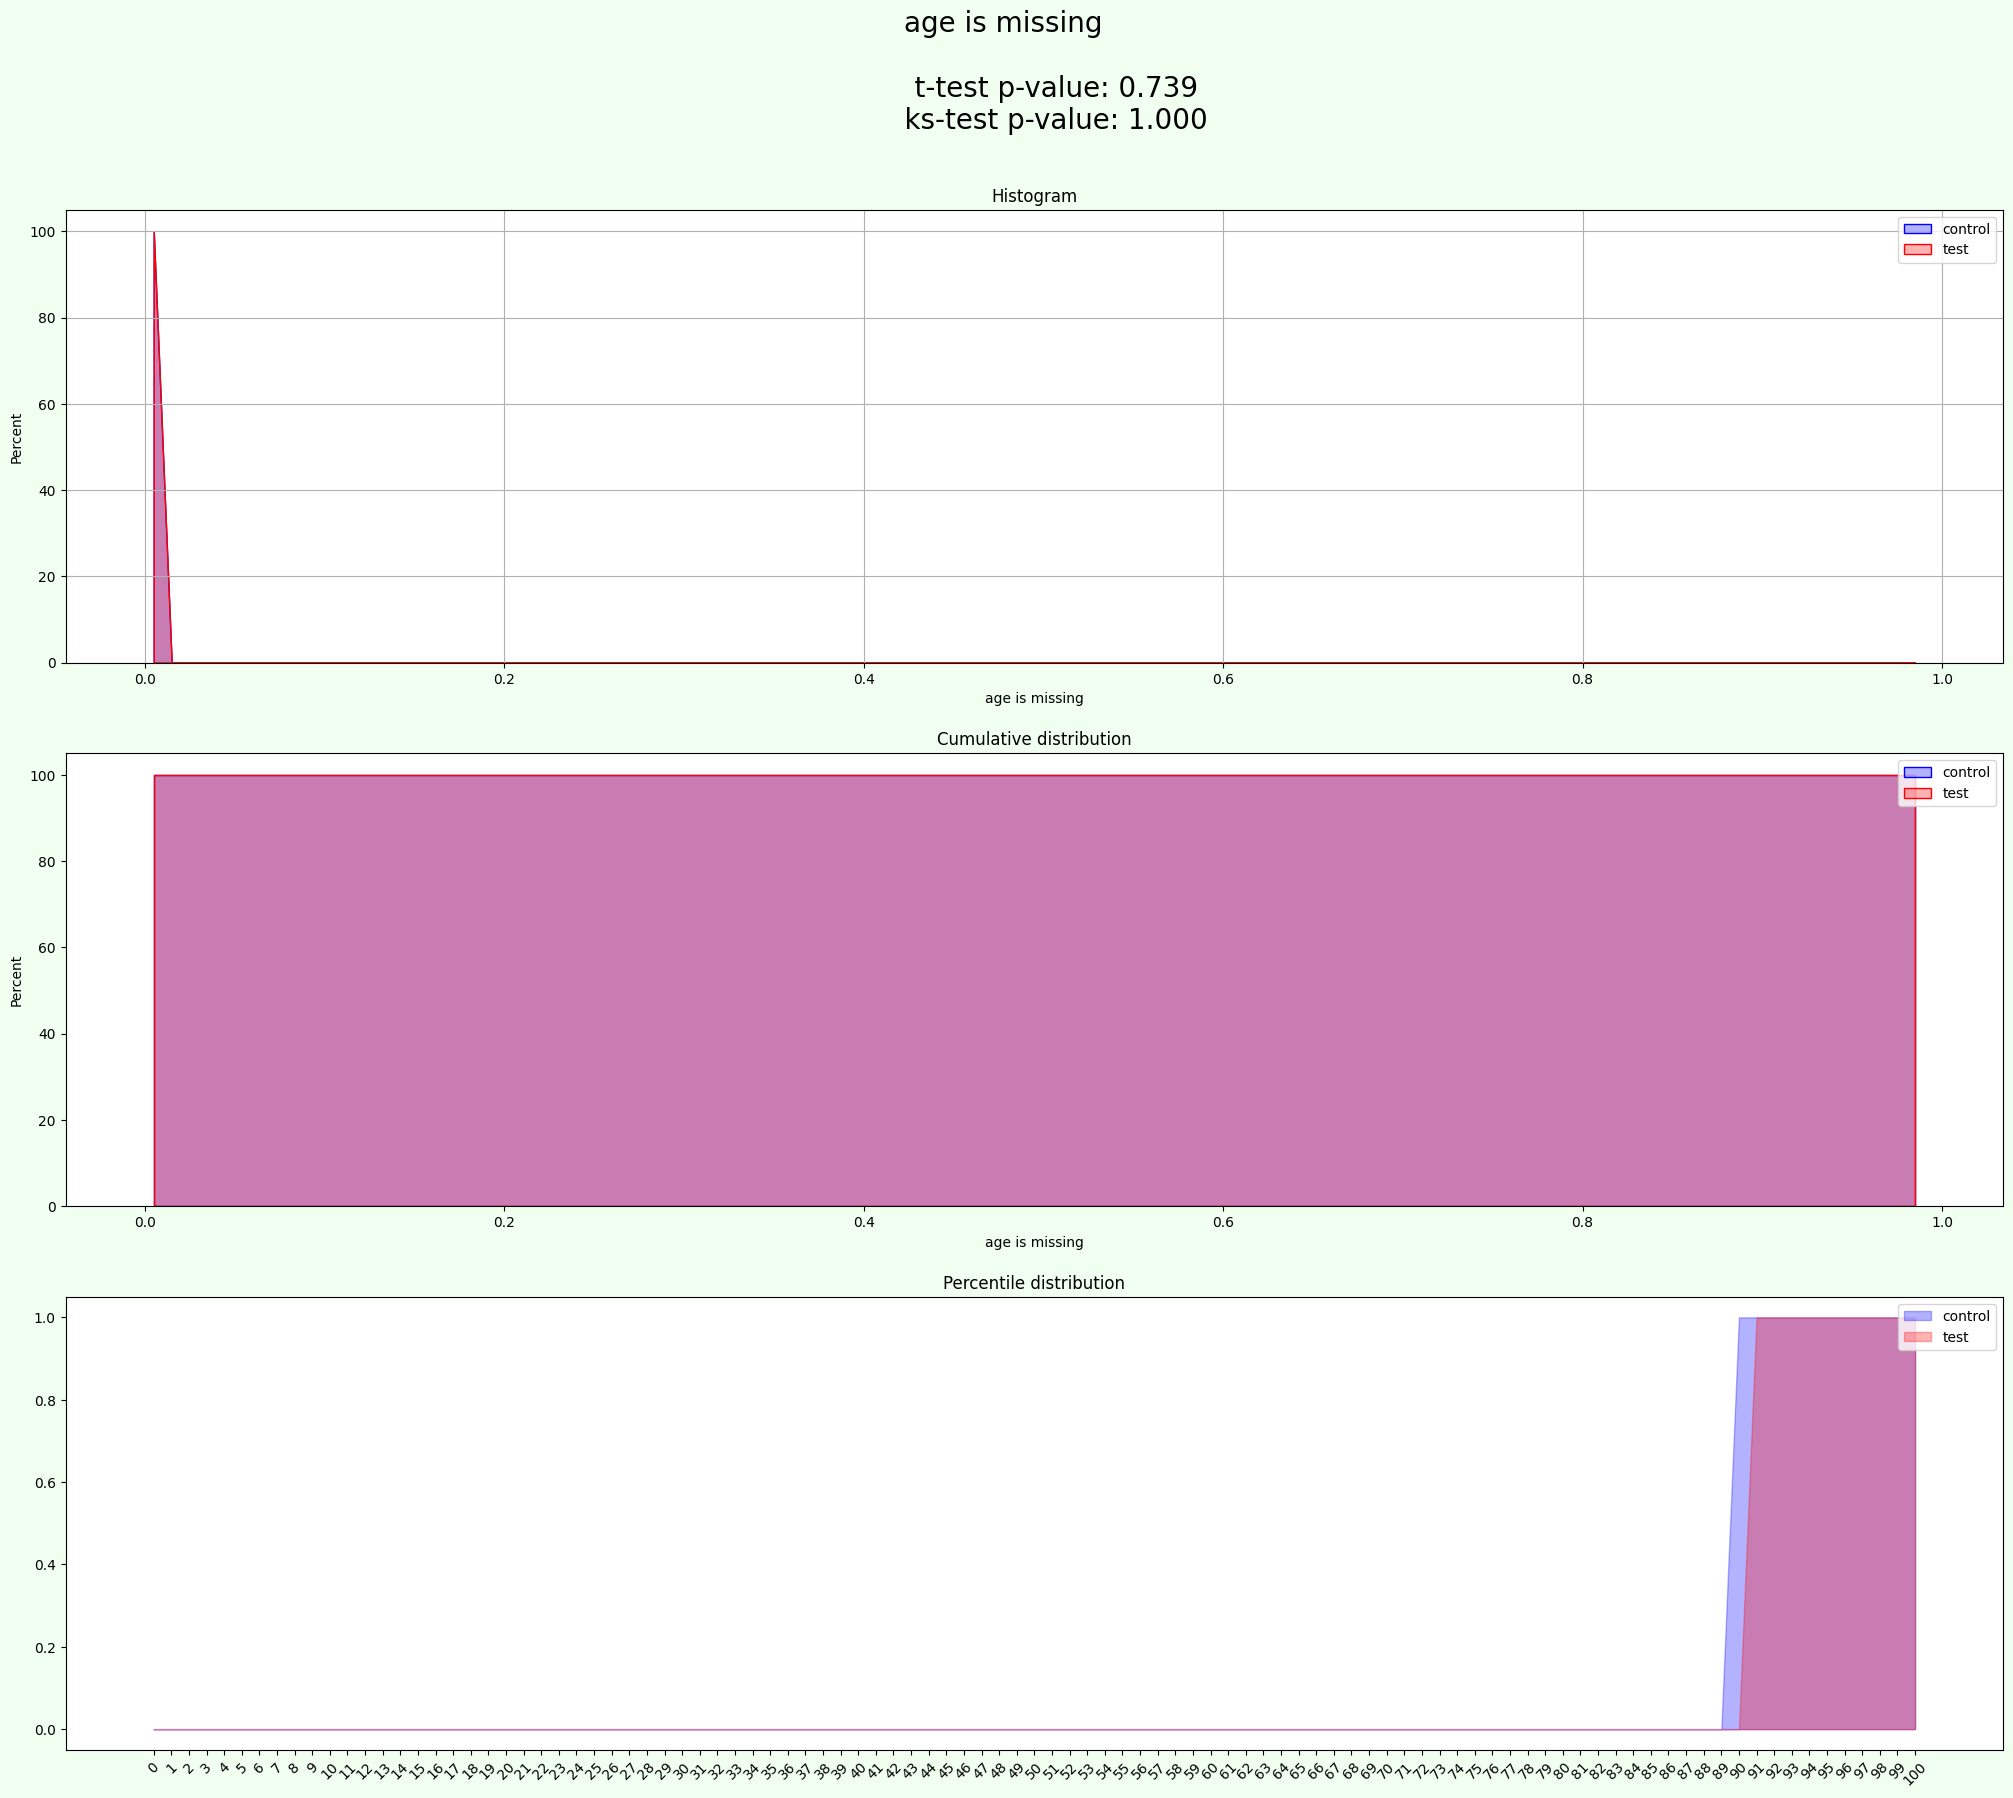

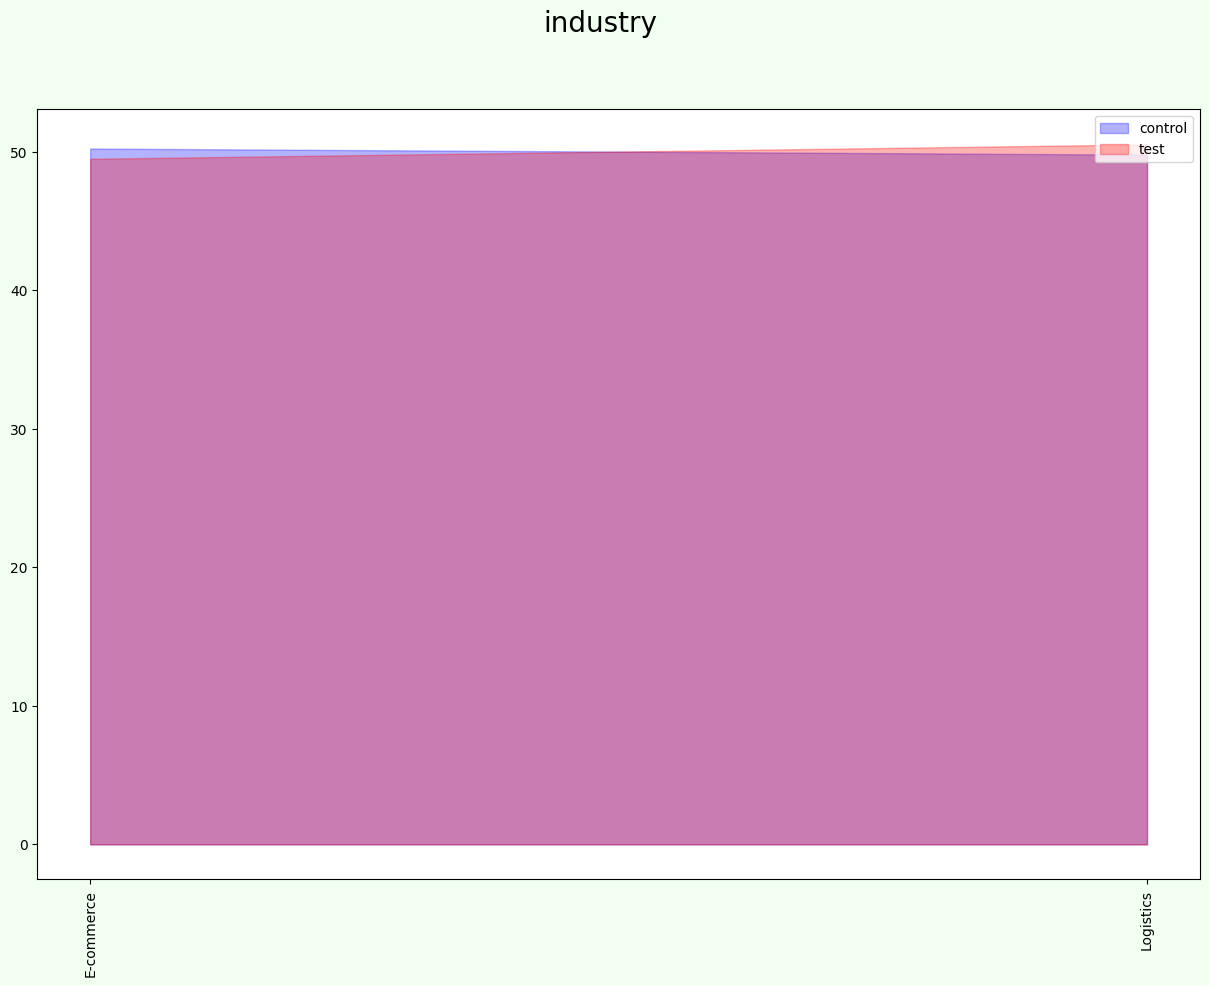

In [6]:
aa_test = AATest(target_fields=["post_spends", "age", "age is missing"], info_cols="user_id")
result = aa_test.process(data, show_plots=True, optimize_groups=True)

In [7]:
result["resume"]

,aa test passed,split is uniform
corrected_spends,OK,OK
age,OK,OK
age is missing,OK,OK


In [12]:
splited_data = result["split"]
splited_data['researched field'] = splited_data.apply(lambda x: x['corrected_spends'] if x["group"] == "test" else x["post_spends"], axis=1)
splited_data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry,corrected_spends,age is missing,group,researched field
0,0,0,0,488.00,414.44,43.00,M,E-commerce,455.15,1,test,455.15
1,1,8,1,512.50,462.22,26.00,None,E-commerce,503.55,0,test,503.55
2,4,1,1,543.00,514.56,18.00,F,E-commerce,556.51,0,test,556.51
3,5,6,1,486.50,486.56,44.00,M,E-commerce,530.36,0,test,530.36
4,7,11,1,496.00,432.89,57.00,M,E-commerce,472.46,0,test,472.46
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9992,0,0,491.50,424.00,29.00,M,E-commerce,470.85,0,control,424.00
9996,9994,0,0,486.00,423.78,69.00,F,Logistics,469.16,0,control,423.78
9997,9995,10,1,538.50,450.44,42.00,M,Logistics,491.69,0,control,450.44
9998,9998,2,1,495.00,523.22,67.00,F,E-commerce,559.78,0,control,523.22


In [13]:
ab_test = ABTest(calc_difference_method="ate", calc_p_value_method="t-test")
ab_result = ab_test.execute(splited_data, target_field="researched field", group_field="group")
ab_result


{'size': {'test': 5000, 'control': 5000},
 'difference': {'ate': 45.26038544353591},
 'p-value': {'t-test': 0.0}}